#### Vou explorar vários métodos de chunking que é um passo essencial para a utilização do método RAG. Esse notebook foi inspirado no repositório (https://github.com/FullStackRetrieval-com/RetrievalTutorials/tree/main) do GitHub
### Métodos de chunking:

- Level 1: Character Splitting - Simple static character chunks of data
- Level 2: Recursive Character Text Splitting - Recursive chunking based on a list of separators
- Level 3: Document Specific Splitting - Various chunking methods for different document types (PDF, Python, Markdown)
- Level 4: Semantic Splitting - Embedding walk based chunking
- Level 5: Agentic Splitting - Experimental method of splitting text with an agent-like system. Good for if you believe that token cost will trend to $0.00

## Level 4: Semantic Splitting: Embedding based chunking

- Gerar frases pequenas isoladas.
- Gerar sentenças compostas sequencias
- Gerar embeddings para cada sentença composta sequencial
- Calcular as similaridades sequenciais para cada par de embeddings sequencias das sentenças compostas sequenciais
- Eu gero os chunks a partir de pontos de quebra de sentenças sequenciais onde a similaridade é abaixo de um determinado limiar gerado por um percentil escolhido.

In [43]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
import re
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

In [34]:
def calculate_cosine_distances(sentences):
    similarities = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']
        
        # Calculate cosine similarity
        similarity = cosine_similarity(embedding_current, embedding_next)[0][0]

        # Append cosine distance to the list
        similarities.append(similarity)

        # Store distance in the dictionary
        sentences[i]['similarity_next'] = similarity

    # Optionally handle the last sentence
    # sentences[-1]['distance_to_next'] = None  # or a default value

    return similarities, sentences

In [2]:
def gerar_embedding(texto: str) -> torch.Tensor:
    # Carregar o tokenizer e o modelo pré-treinado
    tokenizer = BertTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased')
    model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
    
    # Tokenizar o texto de entrada
    inputs = tokenizer(texto, return_tensors='pt', padding=True, truncation=True, max_length=512)
    
    # Obter as saídas do modelo (embeddings)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Extraímos o embedding da última camada do BERT
    embeddings = outputs.last_hidden_state
    
    # Opcionalmente, podemos calcular a média dos embeddings das palavras para obter um vetor fixo
    sentence_embedding = torch.mean(embeddings, dim=1)
    
    return sentence_embedding

In [39]:
# Exemplo de uso
embedding1 = gerar_embedding("A inteligência artificial está transformando a forma como as empresas operam.")
embedding2 = gerar_embedding("Os ataques cibernéticos estão se tornando mais sofisticados e frequentes.")
print(cosine_similarity(embedding1, embedding2)[0][0])


0.6882421


In [16]:
with open('tecnologia.txt') as file:
    essay = file.read()

In [17]:
# Separando o texto em sentenças menores baseado em: '.', '?', and '!'
single_sentences_list = re.split(r'(?<=[.?!])\s+', essay)
print (f"{len(single_sentences_list)} sentenças foram encontradas")

104 sentenças foram encontradas


In [18]:
# 
sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(single_sentences_list)]
sentences[:3]

[{'sentence': '    A inteligência artificial está transformando a forma como as empresas operam.',
  'index': 0},
 {'sentence': 'Os assistentes virtuais, como a Alexa e o Google Assistant, utilizam inteligência artificial para melhorar a experiência do usuário.',
  'index': 1},
 {'sentence': 'A IA pode ser usada para prever tendências de mercado e ajudar nas decisões empresariais.',
  'index': 2}]

In [19]:
sentences = combine_sentences(sentences)

In [20]:
sentences[:3]

[{'sentence': '    A inteligência artificial está transformando a forma como as empresas operam.',
  'index': 0,
  'combined_sentence': '    A inteligência artificial está transformando a forma como as empresas operam. Os assistentes virtuais, como a Alexa e o Google Assistant, utilizam inteligência artificial para melhorar a experiência do usuário.'},
 {'sentence': 'Os assistentes virtuais, como a Alexa e o Google Assistant, utilizam inteligência artificial para melhorar a experiência do usuário.',
  'index': 1,
  'combined_sentence': '    A inteligência artificial está transformando a forma como as empresas operam. Os assistentes virtuais, como a Alexa e o Google Assistant, utilizam inteligência artificial para melhorar a experiência do usuário. A IA pode ser usada para prever tendências de mercado e ajudar nas decisões empresariais.'},
 {'sentence': 'A IA pode ser usada para prever tendências de mercado e ajudar nas decisões empresariais.',
  'index': 2,
  'combined_sentence': 'Os a

In [21]:
embeddings = [gerar_embedding(x['combined_sentence']) for x in sentences]

In [22]:
for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

In [35]:
similarities, sentences = calculate_cosine_distances(sentences)

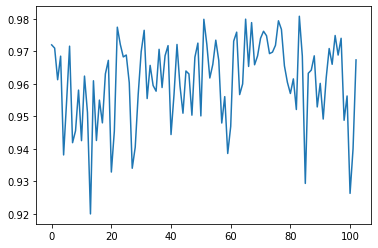

In [40]:
plt.plot(similarities)

In [46]:
# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this
breakpoint_percentile_threshold = 5
breakpoint_distance_threshold = np.percentile(similarities, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
print(breakpoint_distance_threshold)

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in similarities if x <= breakpoint_distance_threshold]) # The amount of distances above your threshold
print(num_distances_above_theshold)

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(similarities) if x <= breakpoint_distance_threshold] # The indices of those breakpoints on your list
print(indices_above_thresh)

0.9381374955177307
6
[4, 13, 20, 27, 85, 100]


In [47]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

'    A inteligência artificial está transformando a forma como as empresas operam. Os assistentes virtuais, como a Alexa e o Google Assistant, utilizam inteligência artificial para melhorar a experiência do usuário. A IA pode ser usada para prever tendências de mercado e ajudar nas decisões empresariais. O aprendizado de máquina é uma subárea da inteligência artificial que está revolucionando muitos setores. Chatbots com IA estão sendo usados para melhorar o atendimento ao cliente.'

### Level 5: Agentic Splitting - Experimental method of splitting text with an agent-like system. Good for if you believe that token cost will trend to $0.00